#### Benchmaking Experiment 001
- Model : Model2
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "glove50-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model5(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, attr_size, max_len=1024, dropout=0.1):
        super(Model5, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        # SAE submodule
        self.EncDenseL = nn.Linear(in_features=ft_size, out_features=attr_size, bias=False)
        self.DecDenseL = nn.Linear(in_features=attr_size, out_features=ft_size, bias=False)
        # override weights
        del self.EncDenseL.weight
        del self.DecDenseL.weight
        # define shared weights
        self.TransMet = nn.Parameter(torch.randn(attr_size, ft_size))

    def forward(self, x):
        x = x.permute(1, 0, 2)
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = out.permute(1, 0, 2)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out = self.DenseL2(out)
        # SAE Operation
        self.EncDenseL.weight = self.TransMet
        self.DecDenseL.weight = self.TransMet.T 
        attr_out = self.EncDenseL(out)
        ft_out = self.DecDenseL(attr_out)
        
        return attr_out, ft_out

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [8]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:00<00:00, 54.62batch/s, loss=11.8]


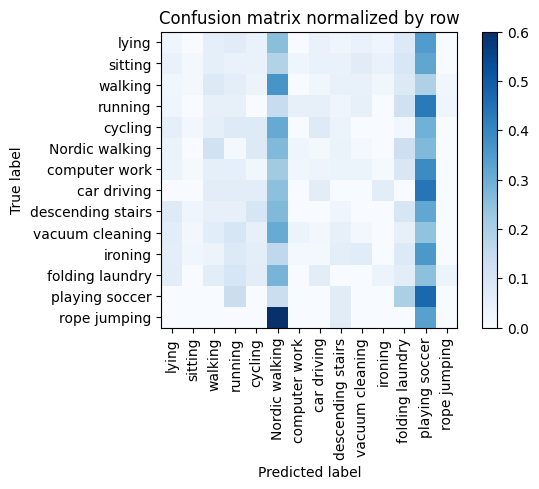

Training Epoch:   7%|▋         | 1/15 [00:09<02:09,  9.24s/it]

Overall accuracy: 0.064



eval: 100%|██████████| 26/26 [00:00<00:00, 53.06batch/s, loss=7.71]


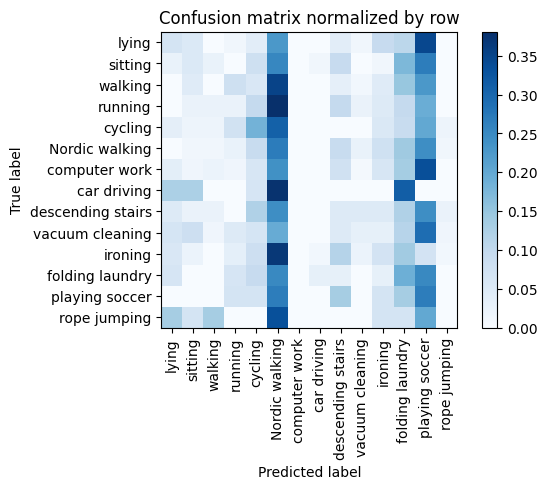

Training Epoch:  13%|█▎        | 2/15 [00:13<01:20,  6.17s/it]

Overall accuracy: 0.075



eval: 100%|██████████| 26/26 [00:00<00:00, 53.39batch/s, loss=1.76]


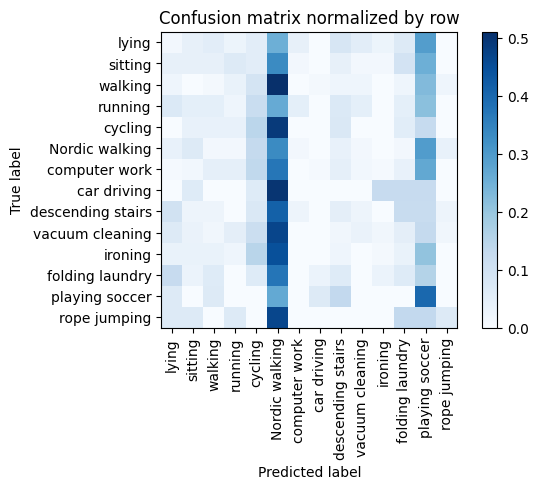

Training Epoch:  20%|██        | 3/15 [00:17<01:03,  5.30s/it]

Overall accuracy: 0.066



eval: 100%|██████████| 26/26 [00:00<00:00, 56.27batch/s, loss=1.59]


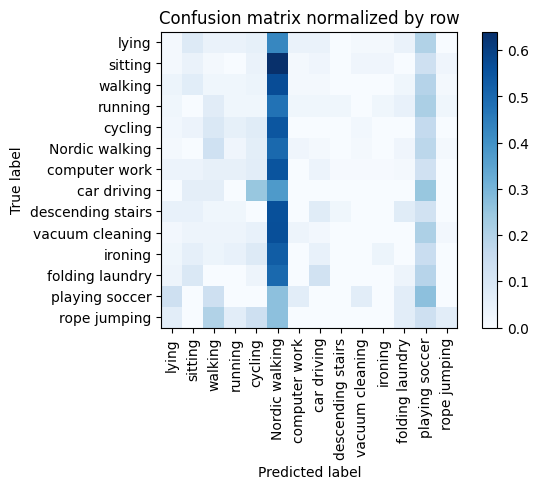

Training Epoch:  27%|██▋       | 4/15 [00:21<00:53,  4.82s/it]

Overall accuracy: 0.074



eval: 100%|██████████| 26/26 [00:00<00:00, 61.76batch/s, loss=2.46]


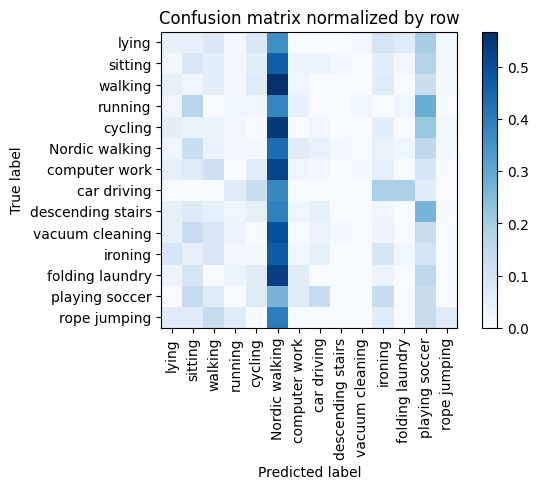

Training Epoch:  33%|███▎      | 5/15 [00:25<00:44,  4.50s/it]

Overall accuracy: 0.077



eval: 100%|██████████| 26/26 [00:00<00:00, 61.76batch/s, loss=0.711]


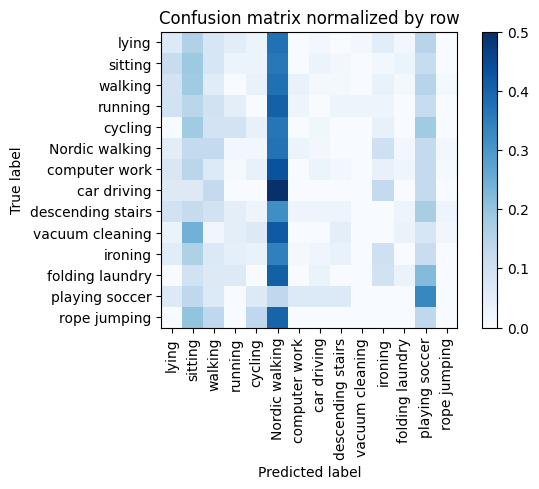

Training Epoch:  40%|████      | 6/15 [00:29<00:38,  4.31s/it]

Overall accuracy: 0.090



eval: 100%|██████████| 26/26 [00:00<00:00, 45.04batch/s, loss=0.641]


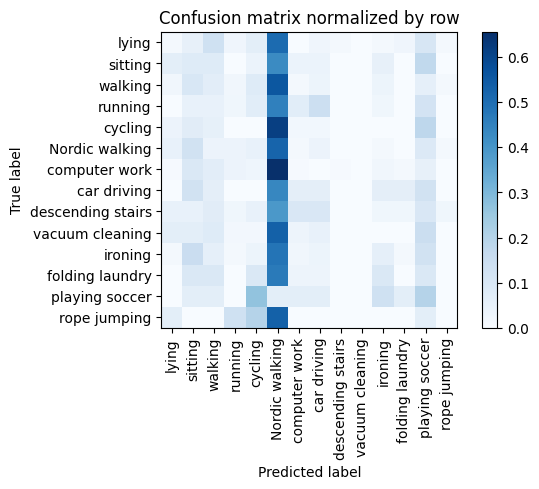

Training Epoch:  47%|████▋     | 7/15 [00:33<00:34,  4.32s/it]

Overall accuracy: 0.080



eval: 100%|██████████| 26/26 [00:00<00:00, 56.16batch/s, loss=1.5]


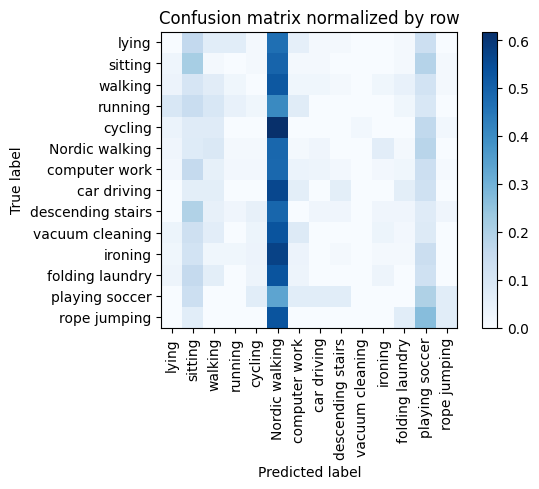

Training Epoch:  53%|█████▎    | 8/15 [00:37<00:29,  4.22s/it]

Overall accuracy: 0.090



eval: 100%|██████████| 26/26 [00:00<00:00, 53.39batch/s, loss=1.41]


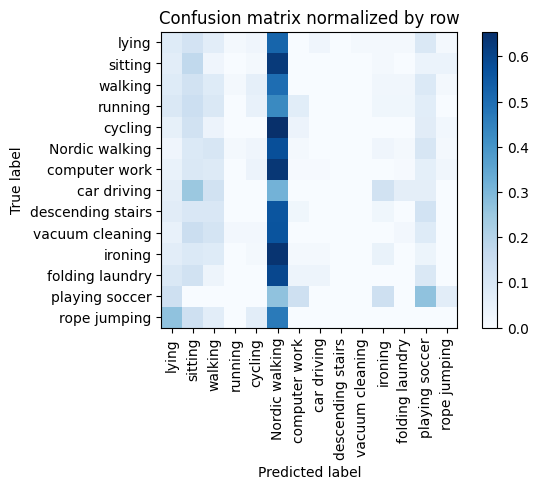

Training Epoch:  60%|██████    | 9/15 [00:42<00:25,  4.31s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 26/26 [00:00<00:00, 55.20batch/s, loss=3.6]


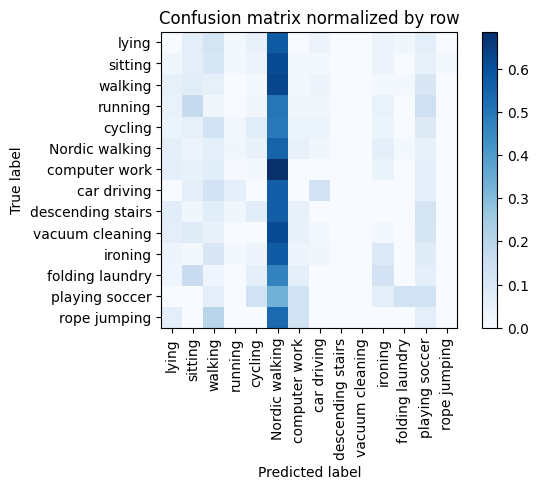

Training Epoch:  67%|██████▋   | 10/15 [00:46<00:21,  4.30s/it]

Overall accuracy: 0.085



eval: 100%|██████████| 26/26 [00:00<00:00, 57.04batch/s, loss=0.642]


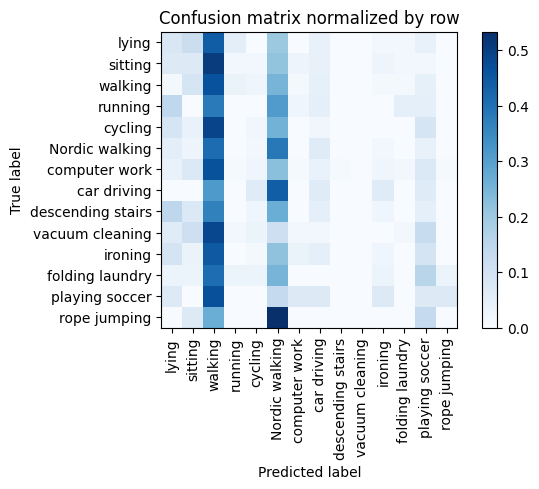

Training Epoch:  73%|███████▎  | 11/15 [00:50<00:16,  4.24s/it]

Overall accuracy: 0.108



eval: 100%|██████████| 26/26 [00:00<00:00, 56.16batch/s, loss=0.688]


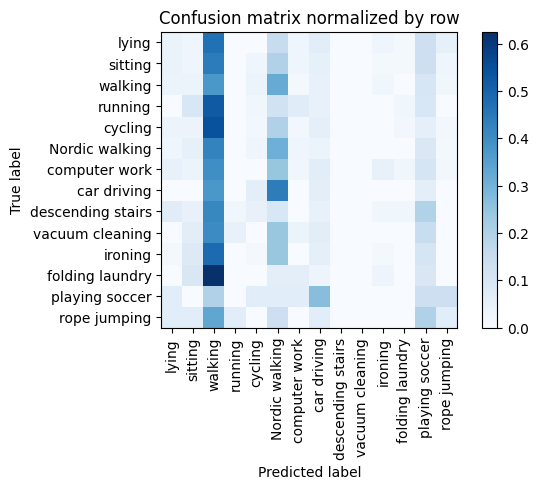

Training Epoch:  80%|████████  | 12/15 [00:54<00:12,  4.25s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 26/26 [00:00<00:00, 58.67batch/s, loss=0.529]


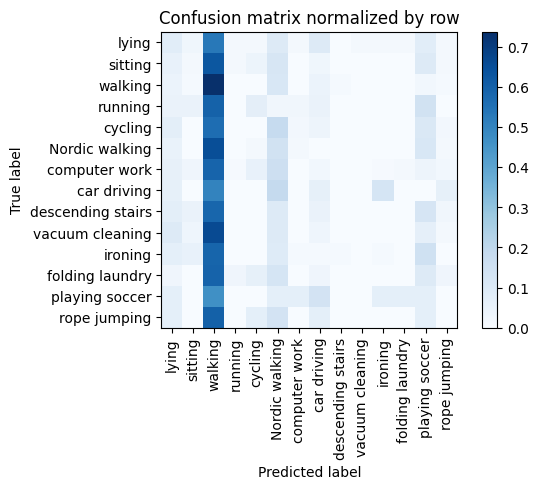

Training Epoch:  87%|████████▋ | 13/15 [00:58<00:08,  4.17s/it]

Overall accuracy: 0.106



eval: 100%|██████████| 26/26 [00:00<00:00, 49.79batch/s, loss=0.617]


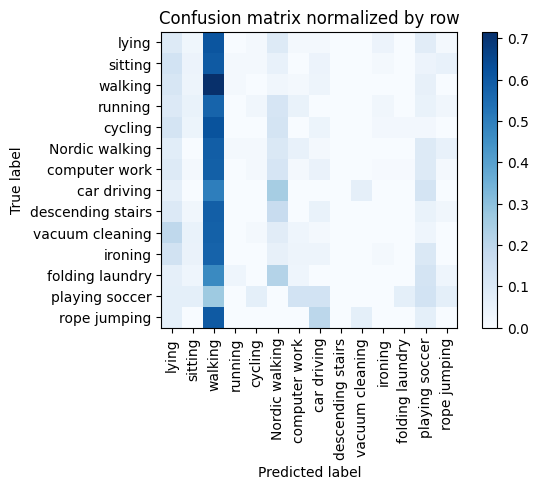

Training Epoch:  93%|█████████▎| 14/15 [01:03<00:04,  4.18s/it]

Overall accuracy: 0.106



eval: 100%|██████████| 26/26 [00:00<00:00, 59.36batch/s, loss=0.565]


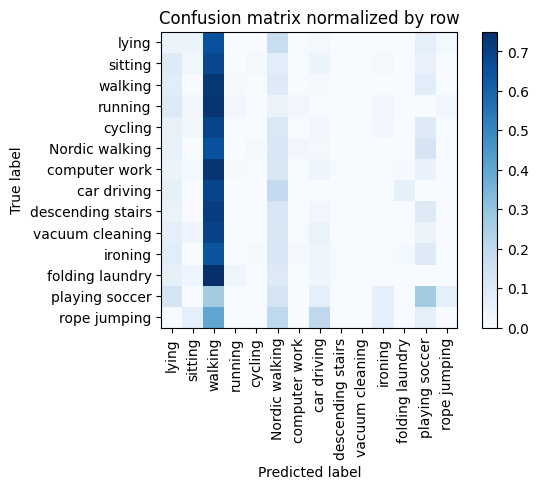

Overall accuracy: 0.102



eval: 100%|██████████| 28/28 [00:00<00:00, 75.73batch/s, loss=0.521]


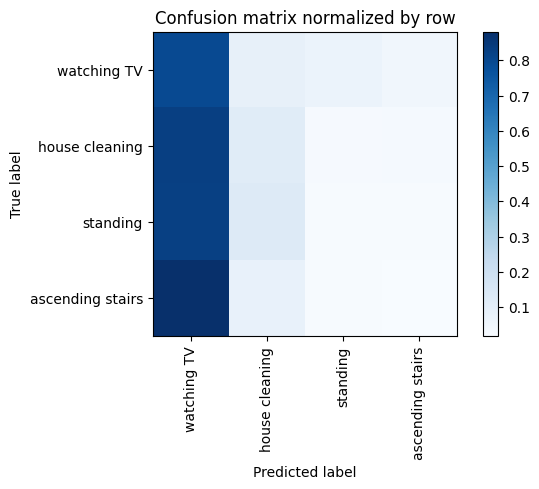

Overall accuracy: 0.164

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.231      0.021      0.038      0.330        289|	 watching TV: 0.827,	house cleaning: 0.131,	ascending stairs: 0.021,	
  house cleaning       0.344      0.117      0.175      0.322        282|	 watching TV: 0.830,	ascending stairs: 0.028,	
ascending stairs       0.130      0.017      0.030      0.202        177|	 watching TV: 0.881,	house cleaning: 0.079,	standing: 0.023,	
     watching TV       0.140      0.797      0.237      0.146        128|	 house cleaning: 0.086,	standing: 0.070,	

----------------------------------------------------------------------------------------------------
     avg / total       0.234      0.164      0.110        1.0        876|	      

{'total_accuracy': 0.1643835616438356, 'precision': 0.2111222242747142, 'recall': 0.2379016687032145, 'f1': 0.12004596522349723}
================ Fold-1 ================
Unseen Class

eval: 100%|██████████| 26/26 [00:00<00:00, 46.76batch/s, loss=60.2]


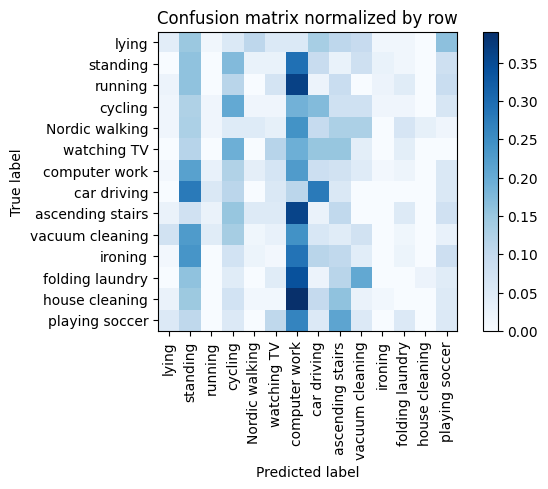

Training Epoch:   7%|▋         | 1/15 [00:04<00:59,  4.24s/it]

Overall accuracy: 0.089



eval: 100%|██████████| 26/26 [00:00<00:00, 53.72batch/s, loss=6.87]


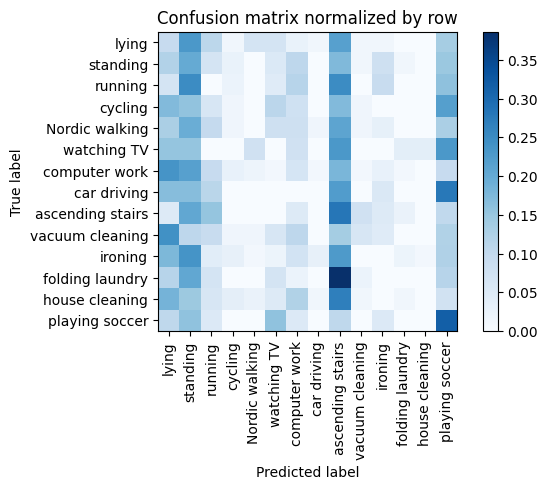

Training Epoch:  13%|█▎        | 2/15 [00:08<00:58,  4.53s/it]

Overall accuracy: 0.062



eval: 100%|██████████| 26/26 [00:00<00:00, 62.65batch/s, loss=2.06]


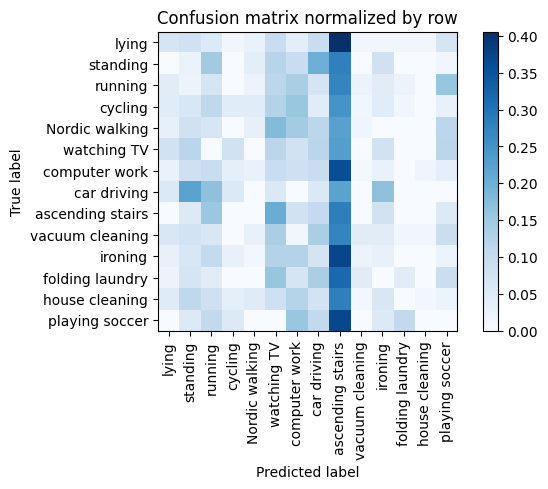

Training Epoch:  20%|██        | 3/15 [00:13<00:52,  4.38s/it]

Overall accuracy: 0.059



eval: 100%|██████████| 26/26 [00:00<00:00, 70.85batch/s, loss=11.8]


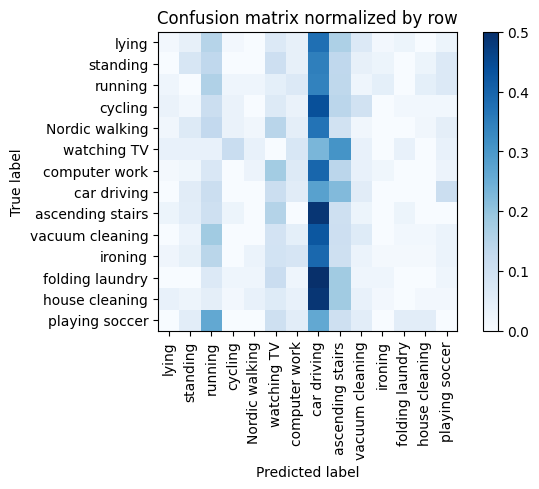

Training Epoch:  27%|██▋       | 4/15 [00:17<00:47,  4.32s/it]

Overall accuracy: 0.048



eval: 100%|██████████| 26/26 [00:00<00:00, 64.68batch/s, loss=2.41]


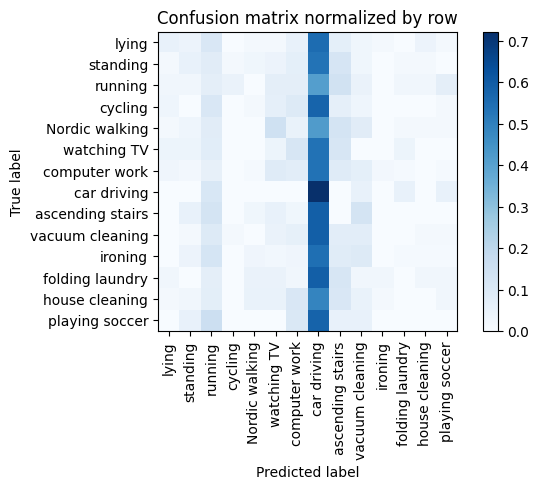

Training Epoch:  33%|███▎      | 5/15 [00:21<00:41,  4.18s/it]

Overall accuracy: 0.047



eval: 100%|██████████| 26/26 [00:00<00:00, 61.03batch/s, loss=1.35]


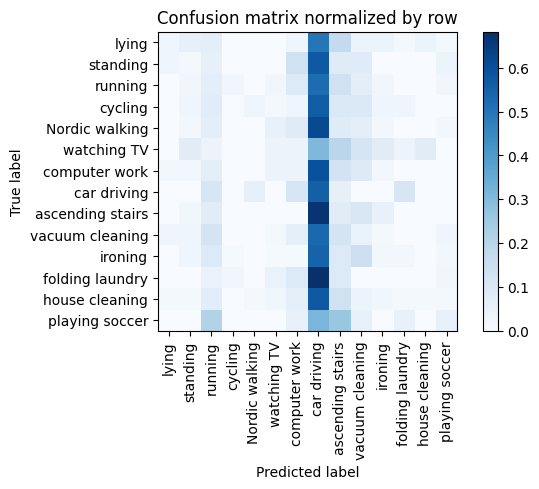

Training Epoch:  40%|████      | 6/15 [00:25<00:36,  4.10s/it]

Overall accuracy: 0.038



eval: 100%|██████████| 26/26 [00:00<00:00, 61.90batch/s, loss=1.8]


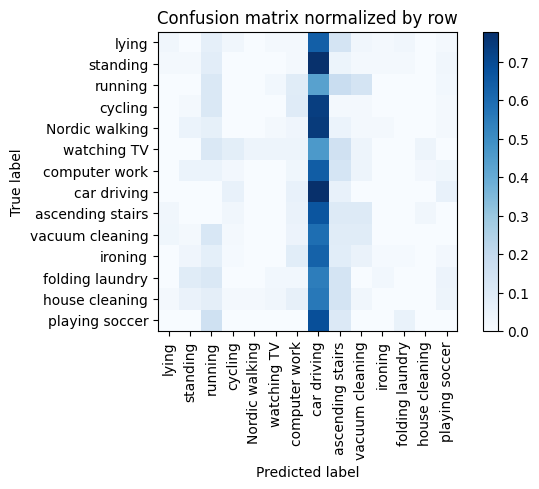

Training Epoch:  47%|████▋     | 7/15 [00:29<00:33,  4.15s/it]

Overall accuracy: 0.045



eval: 100%|██████████| 26/26 [00:00<00:00, 57.14batch/s, loss=1.03]


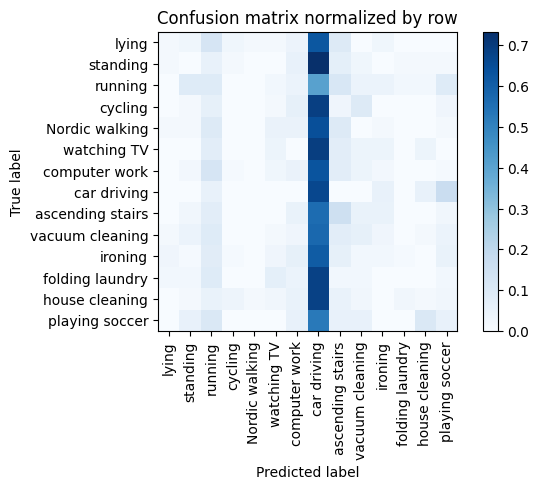

Training Epoch:  53%|█████▎    | 8/15 [00:34<00:31,  4.51s/it]

Overall accuracy: 0.045



eval: 100%|██████████| 26/26 [00:00<00:00, 64.04batch/s, loss=2.63]


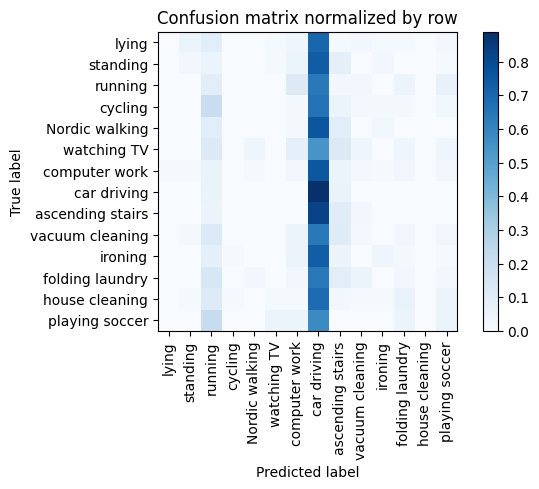

Training Epoch:  60%|██████    | 9/15 [00:40<00:28,  4.80s/it]

Overall accuracy: 0.044



eval: 100%|██████████| 26/26 [00:00<00:00, 57.78batch/s, loss=1.16]


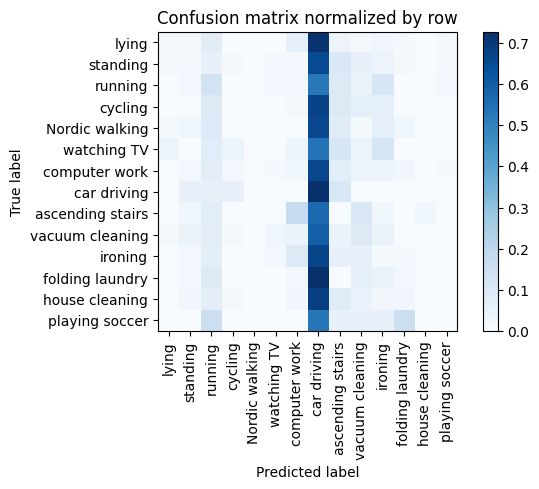

Training Epoch:  67%|██████▋   | 10/15 [00:44<00:22,  4.55s/it]

Overall accuracy: 0.039



eval: 100%|██████████| 26/26 [00:00<00:00, 65.49batch/s, loss=1.17]


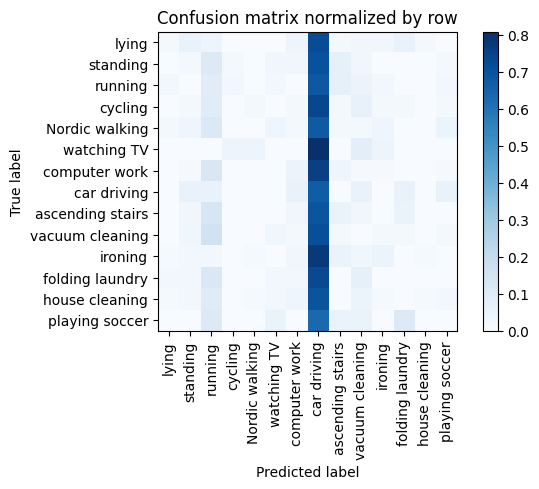

Training Epoch:  73%|███████▎  | 11/15 [00:47<00:17,  4.29s/it]

Overall accuracy: 0.037



eval: 100%|██████████| 26/26 [00:00<00:00, 65.99batch/s, loss=0.6]


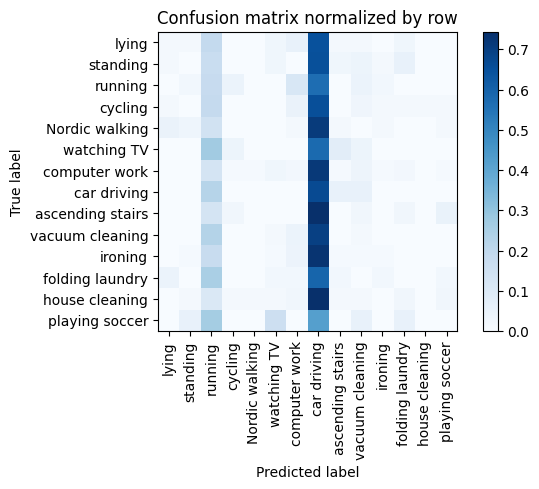

Training Epoch:  80%|████████  | 12/15 [00:51<00:12,  4.05s/it]

Overall accuracy: 0.031



eval: 100%|██████████| 26/26 [00:00<00:00, 68.60batch/s, loss=0.81]


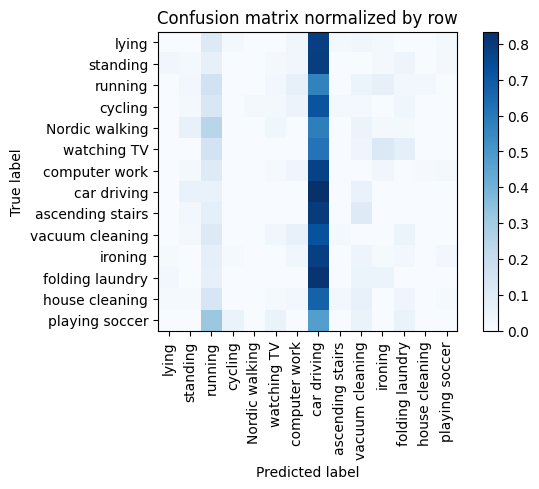

Training Epoch:  87%|████████▋ | 13/15 [00:55<00:07,  3.91s/it]

Overall accuracy: 0.034



eval: 100%|██████████| 26/26 [00:00<00:00, 68.97batch/s, loss=0.566]


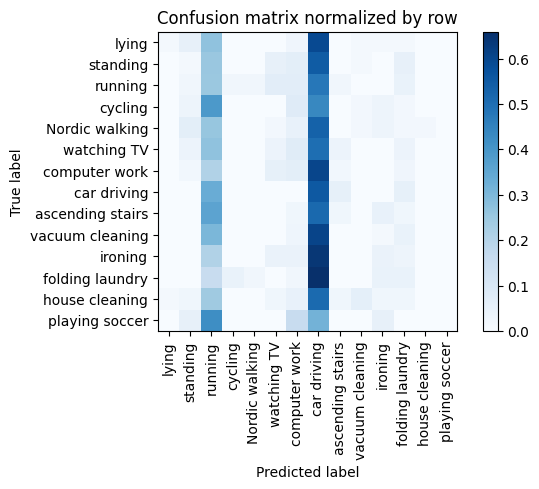

Training Epoch:  93%|█████████▎| 14/15 [00:58<00:03,  3.76s/it]

Overall accuracy: 0.047



eval: 100%|██████████| 26/26 [00:00<00:00, 70.46batch/s, loss=0.602]


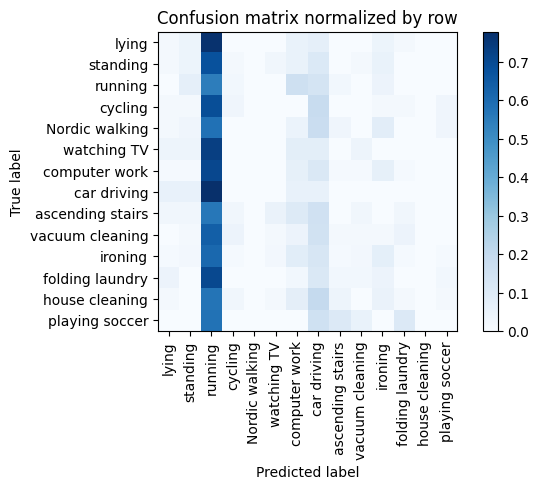

Overall accuracy: 0.056



eval: 100%|██████████| 28/28 [00:00<00:00, 97.90batch/s, loss=0.932]


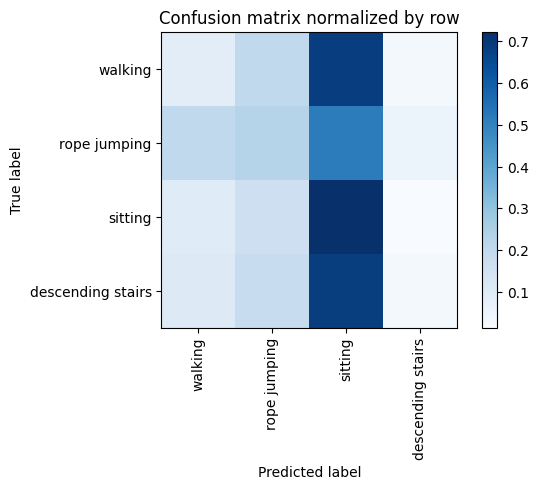

Overall accuracy: 0.296

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.356      0.087      0.140      0.419        366|	 sitting: 0.683,	rope jumping: 0.202,	
          sitting       0.346      0.723      0.468      0.326        285|	 rope jumping: 0.165,	walking: 0.098,	
descending stairs       0.182      0.026      0.046      0.174        152|	 sitting: 0.684,	rope jumping: 0.184,	walking: 0.105,	
     rope jumping       0.097      0.229      0.136      0.080         70|	 sitting: 0.514,	walking: 0.200,	

----------------------------------------------------------------------------------------------------
      avg / total       0.301      0.296      0.230        1.0        873|	      

{'total_accuracy': 0.29553264604810997, 'precision': 0.24499525455901294, 'recall': 0.2662814823945109, 'f1': 0.19753712468225393}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum clean

eval: 100%|██████████| 24/24 [00:00<00:00, 67.61batch/s, loss=42.6]


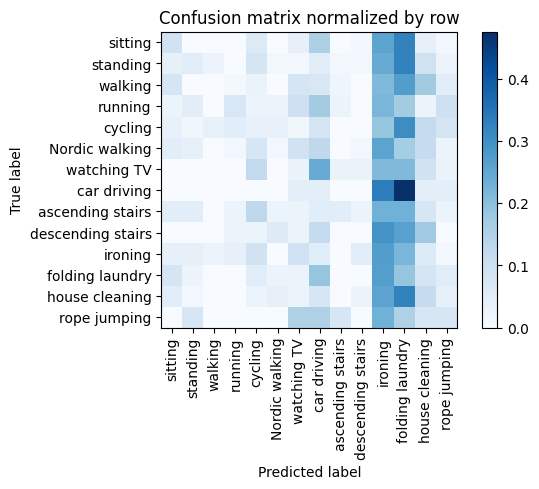

Training Epoch:   7%|▋         | 1/15 [00:03<00:47,  3.40s/it]

Overall accuracy: 0.078



eval: 100%|██████████| 24/24 [00:00<00:00, 67.80batch/s, loss=15.4]


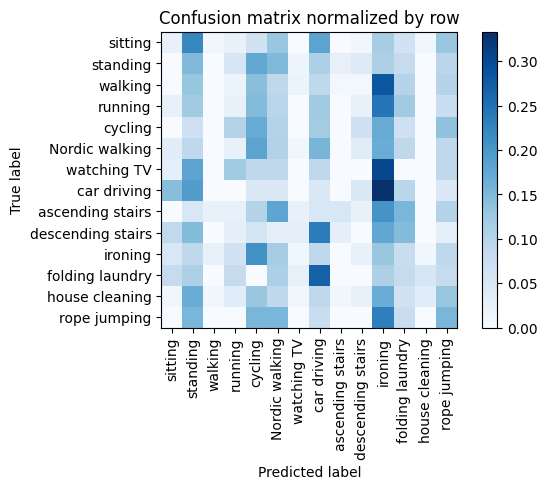

Training Epoch:  13%|█▎        | 2/15 [00:06<00:44,  3.43s/it]

Overall accuracy: 0.070



eval: 100%|██████████| 24/24 [00:00<00:00, 70.38batch/s, loss=5.05]


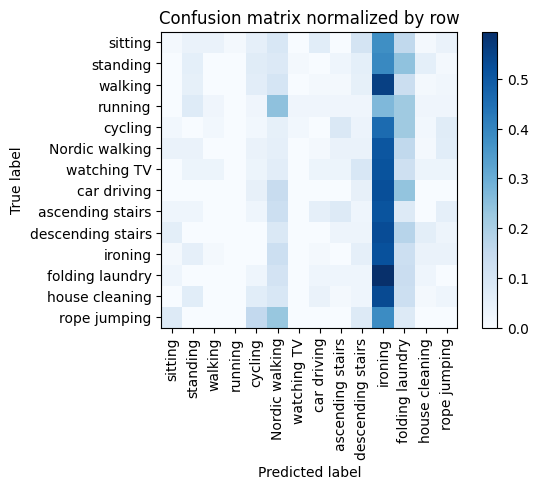

Training Epoch:  20%|██        | 3/15 [00:10<00:41,  3.44s/it]

Overall accuracy: 0.079



eval: 100%|██████████| 24/24 [00:00<00:00, 65.93batch/s, loss=7.57]


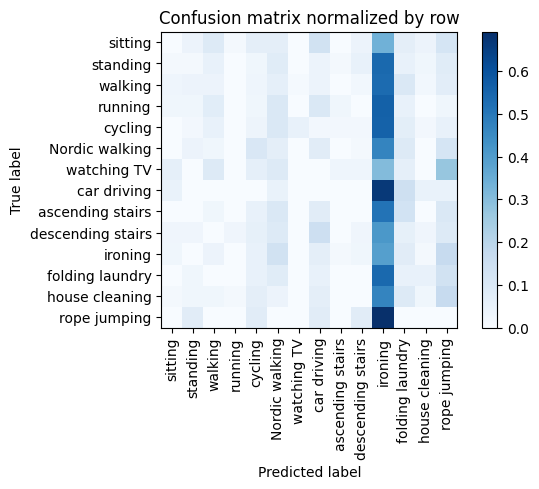

Training Epoch:  27%|██▋       | 4/15 [00:13<00:37,  3.44s/it]

Overall accuracy: 0.062



eval: 100%|██████████| 24/24 [00:00<00:00, 68.01batch/s, loss=3.46]


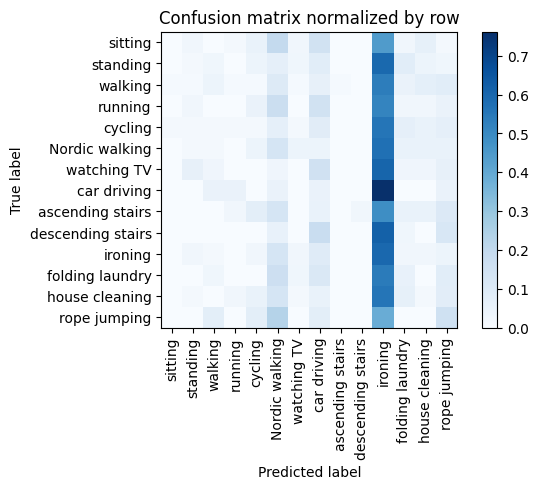

Training Epoch:  33%|███▎      | 5/15 [00:17<00:34,  3.44s/it]

Overall accuracy: 0.090



eval: 100%|██████████| 24/24 [00:00<00:00, 57.97batch/s, loss=1.4]


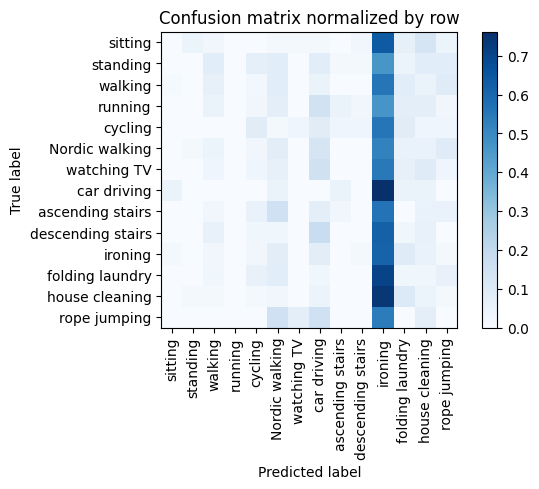

Training Epoch:  40%|████      | 6/15 [00:20<00:31,  3.45s/it]

Overall accuracy: 0.091



eval: 100%|██████████| 24/24 [00:00<00:00, 57.28batch/s, loss=0.794]


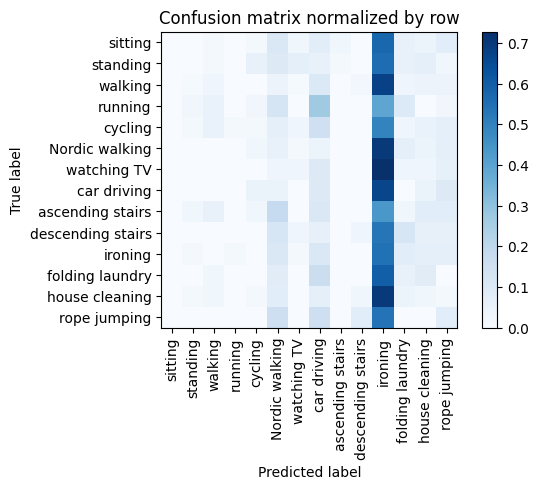

Training Epoch:  47%|████▋     | 7/15 [00:24<00:28,  3.52s/it]

Overall accuracy: 0.078



eval: 100%|██████████| 24/24 [00:00<00:00, 65.40batch/s, loss=6.62]


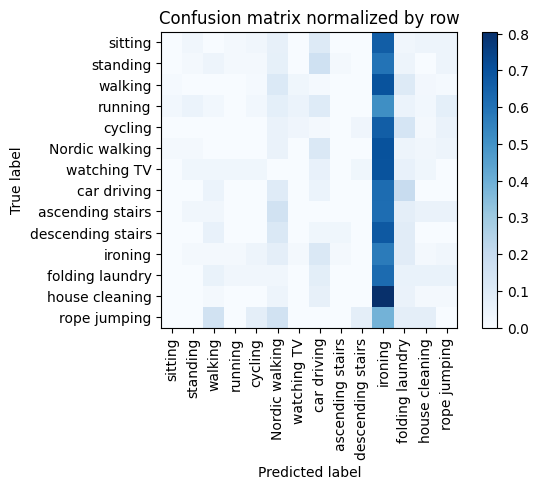

Training Epoch:  53%|█████▎    | 8/15 [00:27<00:24,  3.55s/it]

Overall accuracy: 0.070



eval: 100%|██████████| 24/24 [00:00<00:00, 60.14batch/s, loss=1.03]


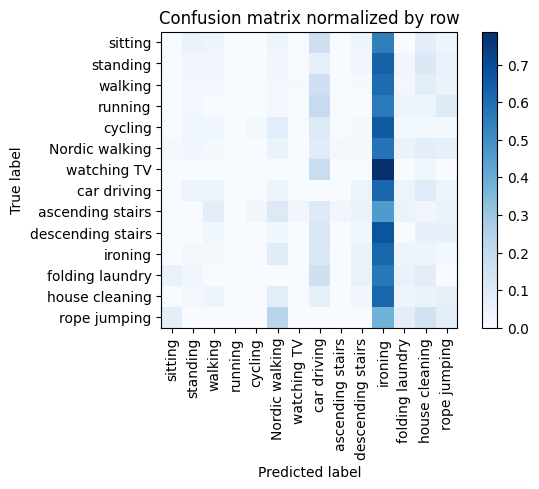

Training Epoch:  60%|██████    | 9/15 [00:31<00:21,  3.56s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 24/24 [00:00<00:00, 67.80batch/s, loss=0.716]


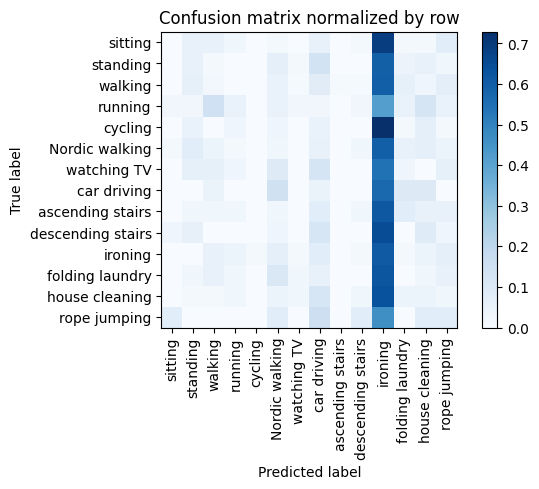

Training Epoch:  67%|██████▋   | 10/15 [00:35<00:18,  3.64s/it]

Overall accuracy: 0.082



eval: 100%|██████████| 24/24 [00:00<00:00, 53.03batch/s, loss=0.842]


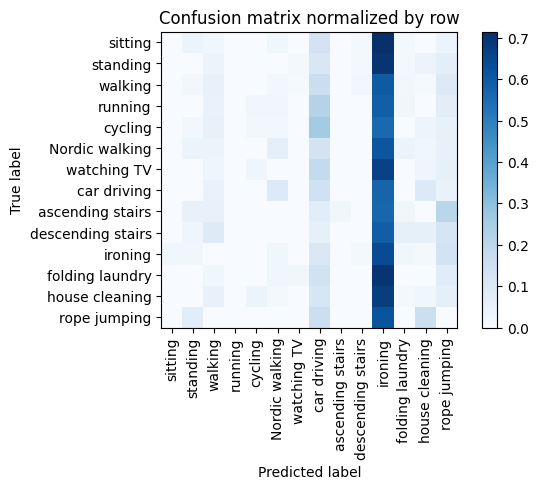

Training Epoch:  73%|███████▎  | 11/15 [00:39<00:14,  3.72s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 24/24 [00:00<00:00, 64.00batch/s, loss=0.598]


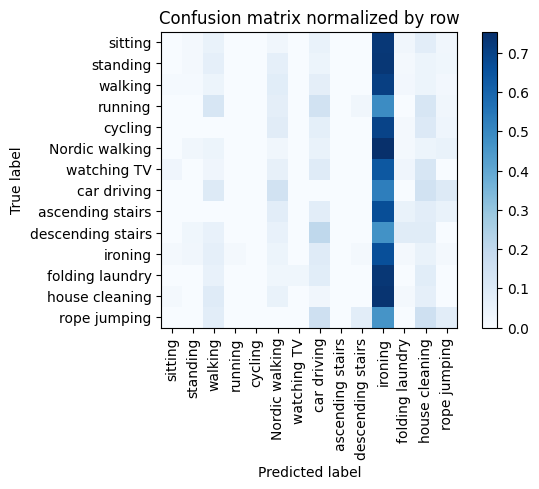

Training Epoch:  80%|████████  | 12/15 [00:43<00:11,  3.75s/it]

Overall accuracy: 0.084



eval: 100%|██████████| 24/24 [00:00<00:00, 61.70batch/s, loss=0.548]


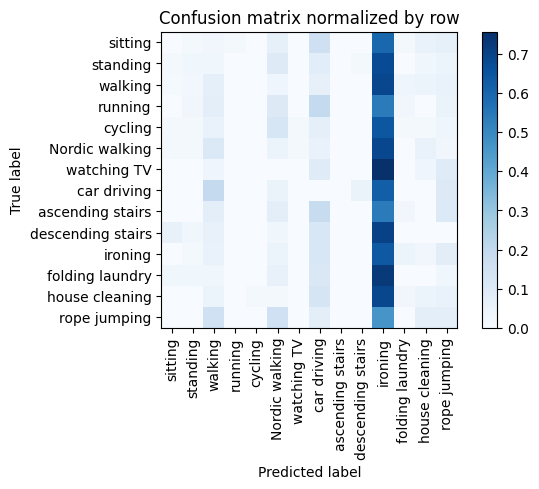

Training Epoch:  87%|████████▋ | 13/15 [00:46<00:07,  3.76s/it]

Overall accuracy: 0.086



eval: 100%|██████████| 24/24 [00:00<00:00, 64.08batch/s, loss=0.511]


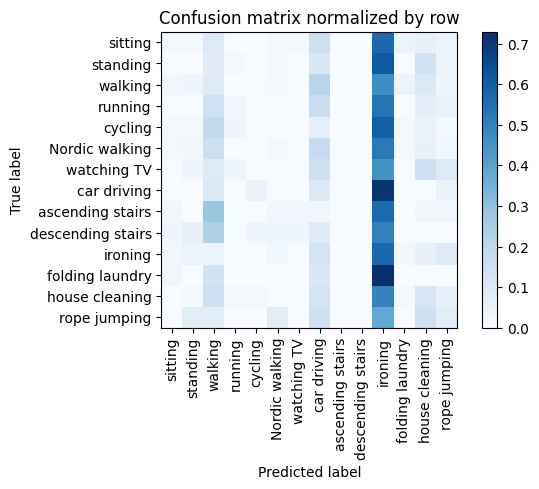

Training Epoch:  93%|█████████▎| 14/15 [00:50<00:03,  3.82s/it]

Overall accuracy: 0.090



eval: 100%|██████████| 24/24 [00:00<00:00, 62.78batch/s, loss=0.482]


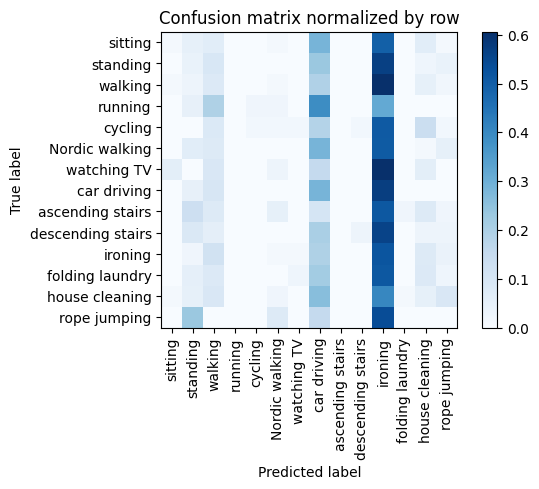

Overall accuracy: 0.084



eval: 100%|██████████| 35/35 [00:00<00:00, 67.04batch/s, loss=0.463]


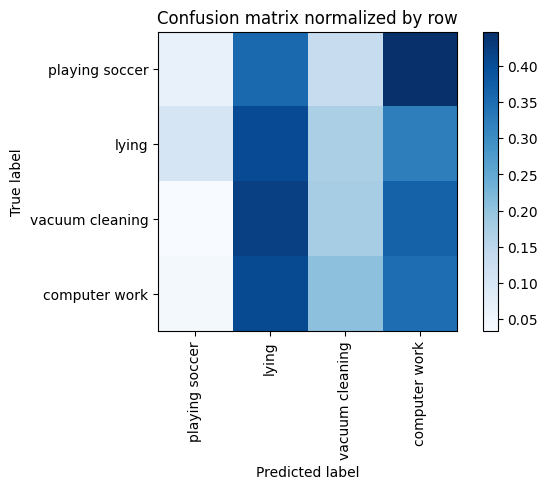

Overall accuracy: 0.302

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.425      0.349      0.383      0.430        475|	 lying: 0.404,	vacuum cleaning: 0.206,	
          lying       0.257      0.404      0.314      0.258        285|	 computer work: 0.323,	vacuum cleaning: 0.172,	
vacuum cleaning       0.234      0.178      0.203      0.243        269|	 lying: 0.420,	computer work: 0.368,	
 playing soccer       0.081      0.066      0.072      0.069         76|	 computer work: 0.447,	lying: 0.355,	vacuum cleaning: 0.132,	

----------------------------------------------------------------------------------------------------
    avg / total       0.311      0.302      0.300        1.0       1105|	      

{'total_accuracy': 0.302262443438914, 'precision': 0.24915365648339016, 'recall': 0.24930264788364964, 'f1': 0.24314372210978893}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic wa

eval: 100%|██████████| 27/27 [00:00<00:00, 68.70batch/s, loss=24.3]


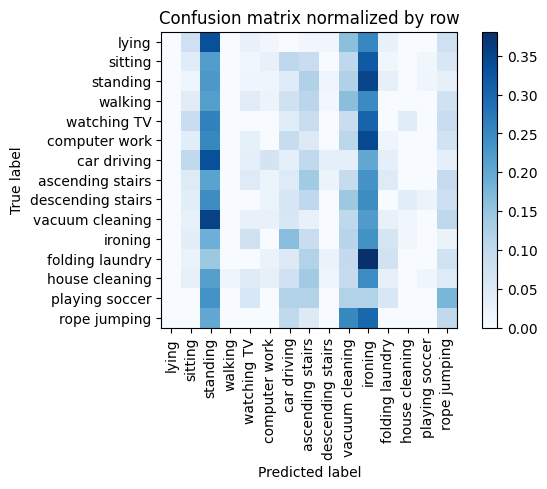

Training Epoch:   7%|▋         | 1/15 [00:03<00:55,  3.93s/it]

Overall accuracy: 0.065



eval: 100%|██████████| 27/27 [00:00<00:00, 70.13batch/s, loss=3.57]


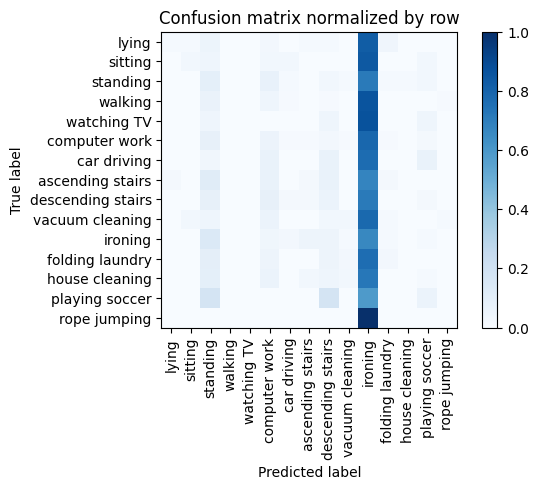

Training Epoch:  13%|█▎        | 2/15 [00:07<00:49,  3.84s/it]

Overall accuracy: 0.089



eval: 100%|██████████| 27/27 [00:00<00:00, 65.67batch/s, loss=1.47]


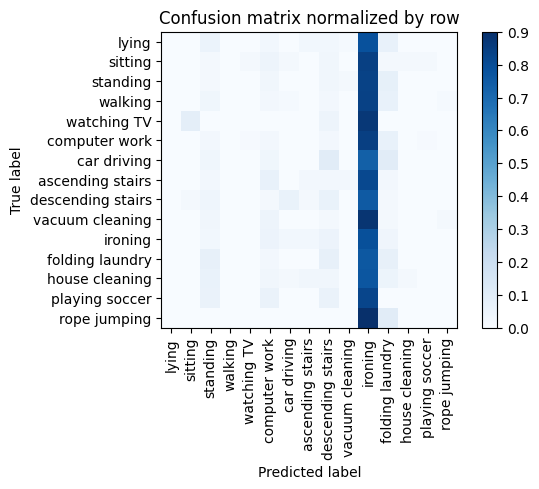

Training Epoch:  20%|██        | 3/15 [00:11<00:45,  3.81s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 27/27 [00:00<00:00, 64.13batch/s, loss=1.47]


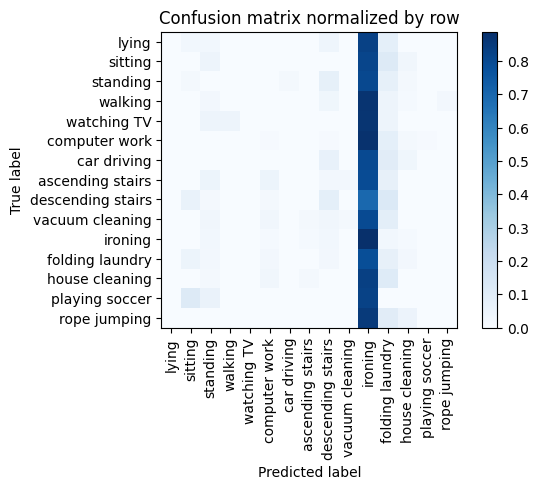

Training Epoch:  27%|██▋       | 4/15 [00:15<00:41,  3.79s/it]

Overall accuracy: 0.093



eval: 100%|██████████| 27/27 [00:00<00:00, 65.69batch/s, loss=12.6]


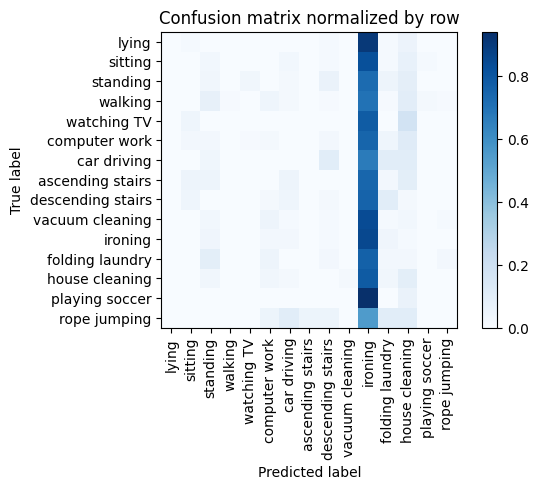

Training Epoch:  33%|███▎      | 5/15 [00:19<00:37,  3.80s/it]

Overall accuracy: 0.094



eval: 100%|██████████| 27/27 [00:00<00:00, 66.21batch/s, loss=1.17]


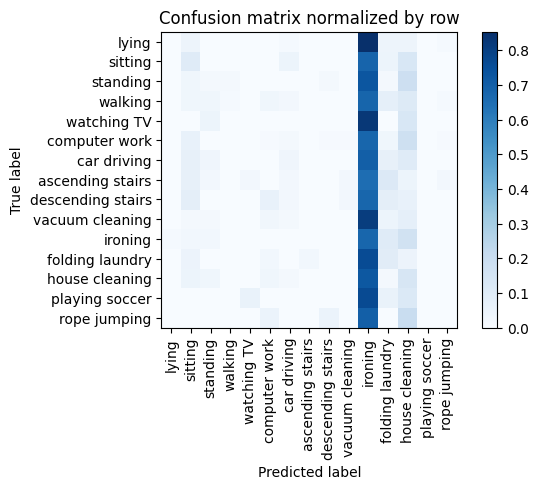

Training Epoch:  40%|████      | 6/15 [00:21<00:31,  3.45s/it]

Overall accuracy: 0.090



eval: 100%|██████████| 27/27 [00:00<00:00, 103.45batch/s, loss=1.19]


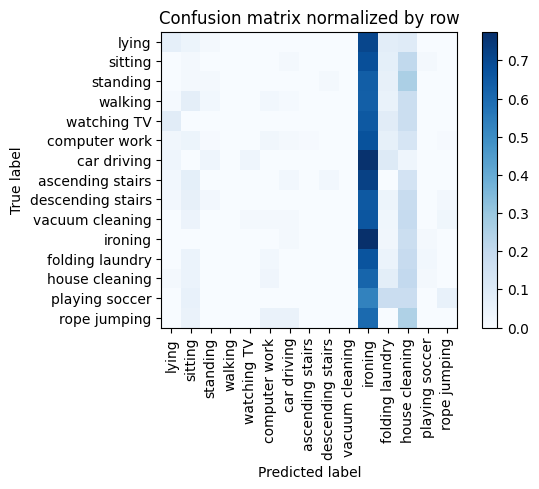

Training Epoch:  47%|████▋     | 7/15 [00:24<00:24,  3.09s/it]

Overall accuracy: 0.101



eval: 100%|██████████| 27/27 [00:00<00:00, 117.39batch/s, loss=1.51]


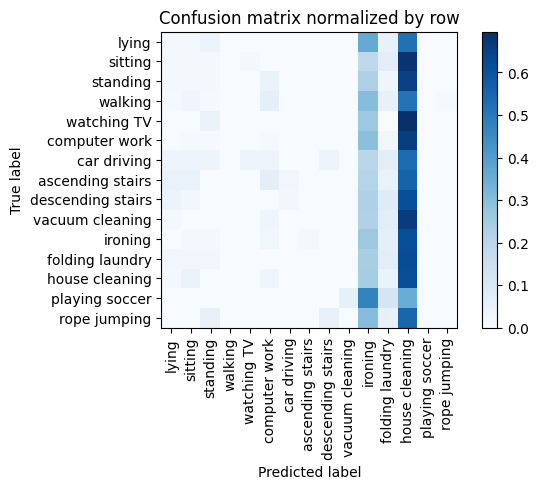

Training Epoch:  53%|█████▎    | 8/15 [00:26<00:19,  2.82s/it]

Overall accuracy: 0.079



eval: 100%|██████████| 27/27 [00:00<00:00, 112.97batch/s, loss=0.514]


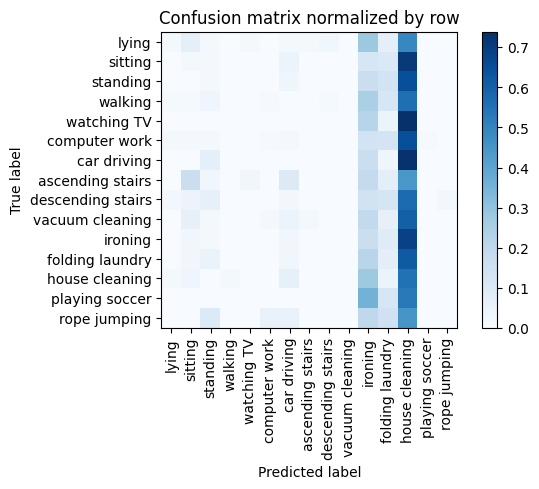

Training Epoch:  60%|██████    | 9/15 [00:28<00:15,  2.61s/it]

Overall accuracy: 0.065



eval: 100%|██████████| 27/27 [00:00<00:00, 116.38batch/s, loss=0.489]


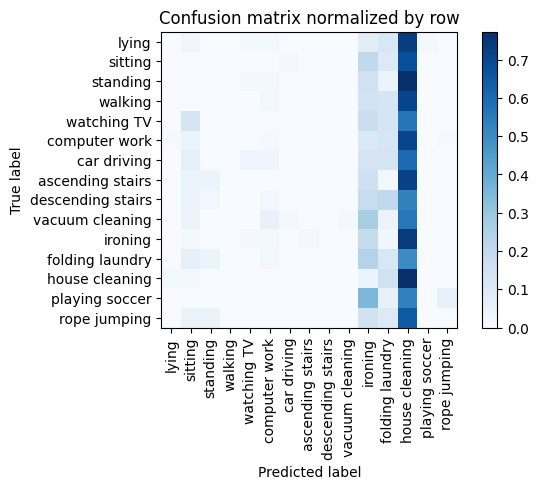

Training Epoch:  67%|██████▋   | 10/15 [00:30<00:12,  2.46s/it]

Overall accuracy: 0.083



eval: 100%|██████████| 27/27 [00:00<00:00, 114.89batch/s, loss=0.549]


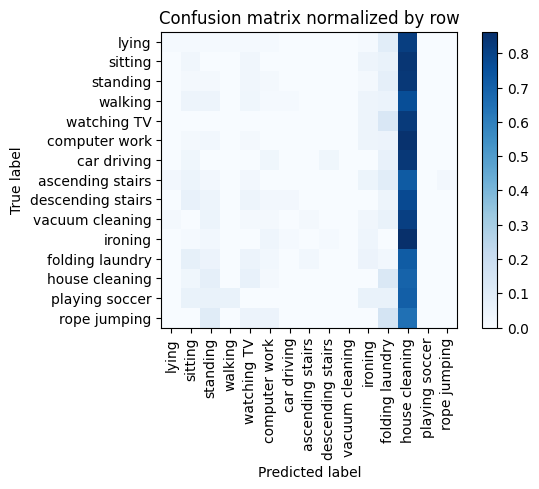

Training Epoch:  73%|███████▎  | 11/15 [00:32<00:09,  2.39s/it]

Overall accuracy: 0.061



eval: 100%|██████████| 27/27 [00:00<00:00, 105.88batch/s, loss=0.499]


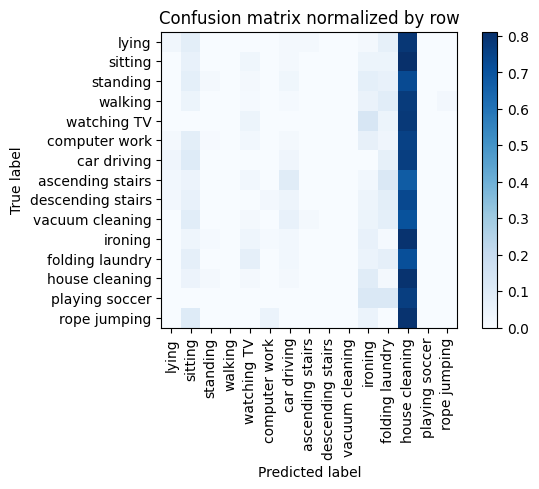

Training Epoch:  80%|████████  | 12/15 [00:35<00:07,  2.37s/it]

Overall accuracy: 0.080



eval: 100%|██████████| 27/27 [00:00<00:00, 86.26batch/s, loss=0.681]


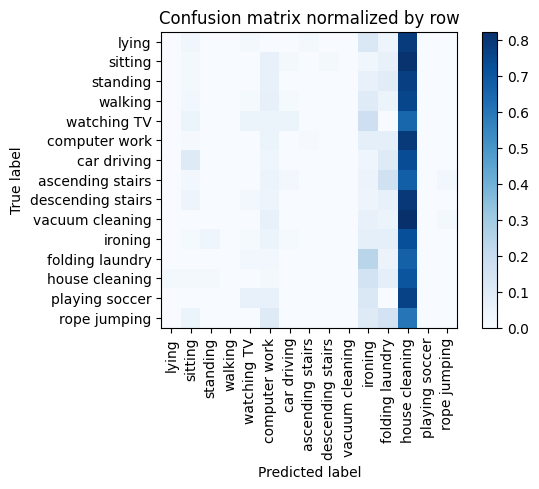

Training Epoch:  87%|████████▋ | 13/15 [00:37<00:04,  2.39s/it]

Overall accuracy: 0.072



eval: 100%|██████████| 27/27 [00:00<00:00, 92.47batch/s, loss=0.455]


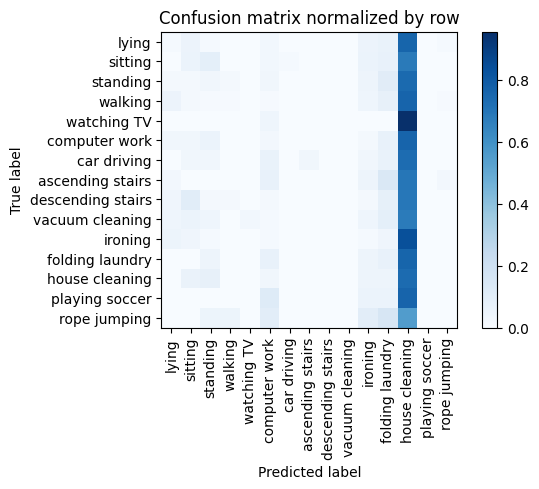

Training Epoch:  93%|█████████▎| 14/15 [00:39<00:02,  2.34s/it]

Overall accuracy: 0.073



eval: 100%|██████████| 27/27 [00:00<00:00, 97.12batch/s, loss=0.443]


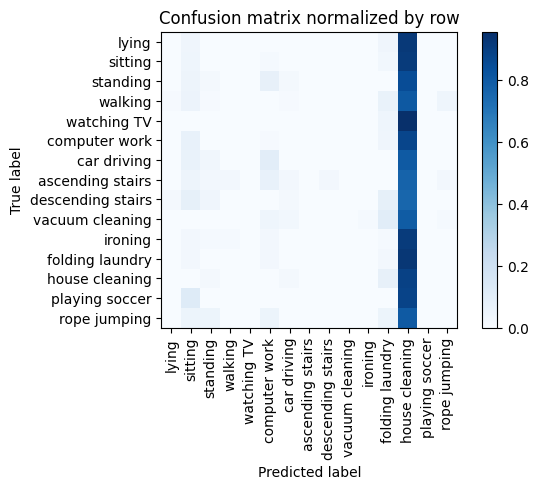

Overall accuracy: 0.074



eval: 100%|██████████| 22/22 [00:00<00:00, 114.58batch/s, loss=1.58]


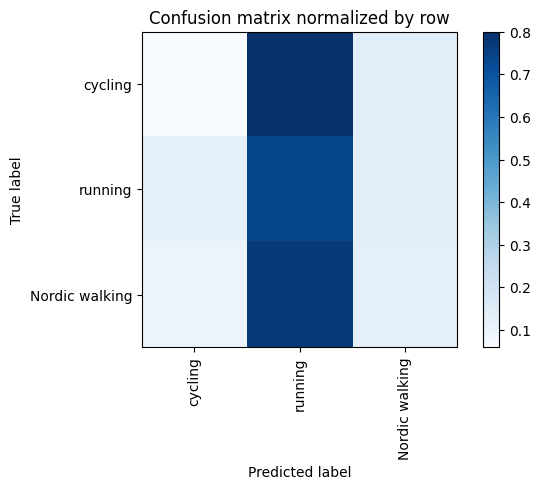

Overall accuracy: 0.234

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.402      0.128      0.195      0.420        288|	 running: 0.771,	cycling: 0.101,	
       cycling       0.238      0.060      0.096      0.365        250|	 running: 0.800,	Nordic walking: 0.140,	
       running       0.204      0.735      0.319      0.215        147|	 Nordic walking: 0.136,	cycling: 0.129,	

----------------------------------------------------------------------------------------------------
   avg / total       0.300      0.234      0.185        1.0        685|	      

{'total_accuracy': 0.23357664233576642, 'precision': 0.28134757868145893, 'recall': 0.30772203325774755, 'f1': 0.2032127134510099}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 83.33batch/s, loss=54.6]


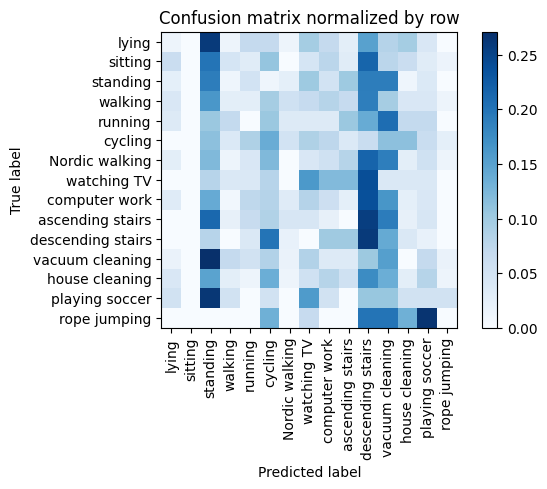

Training Epoch:   7%|▋         | 1/15 [00:02<00:33,  2.41s/it]

Overall accuracy: 0.073



eval: 100%|██████████| 28/28 [00:00<00:00, 105.66batch/s, loss=7.47]


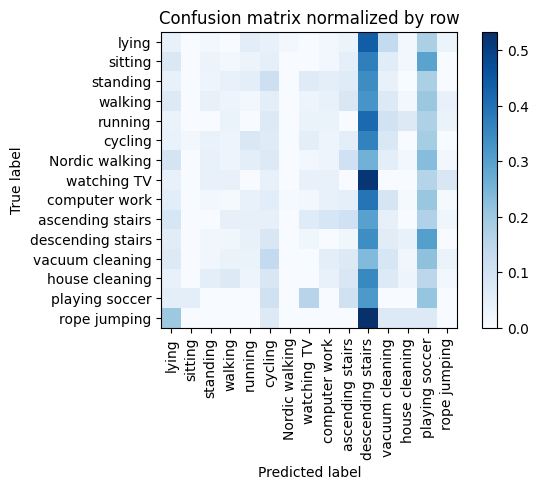

Training Epoch:  13%|█▎        | 2/15 [00:04<00:29,  2.31s/it]

Overall accuracy: 0.058



eval: 100%|██████████| 28/28 [00:00<00:00, 115.23batch/s, loss=2.5]


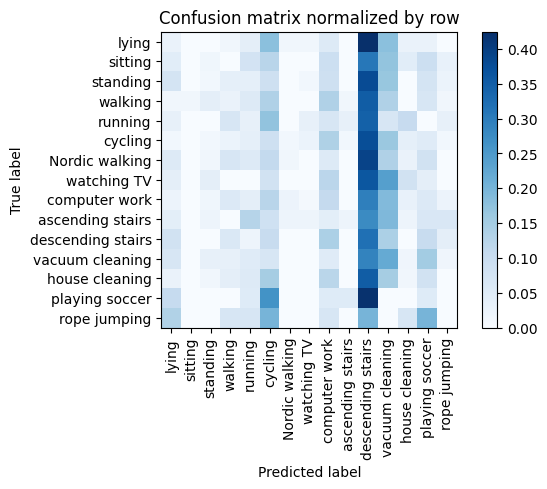

Training Epoch:  20%|██        | 3/15 [00:06<00:27,  2.26s/it]

Overall accuracy: 0.067



eval: 100%|██████████| 28/28 [00:00<00:00, 108.53batch/s, loss=1.49]


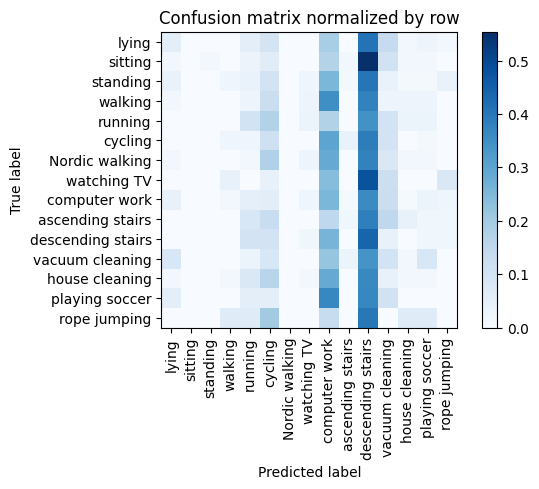

Training Epoch:  27%|██▋       | 4/15 [00:09<00:24,  2.27s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 28/28 [00:00<00:00, 115.23batch/s, loss=1.19]


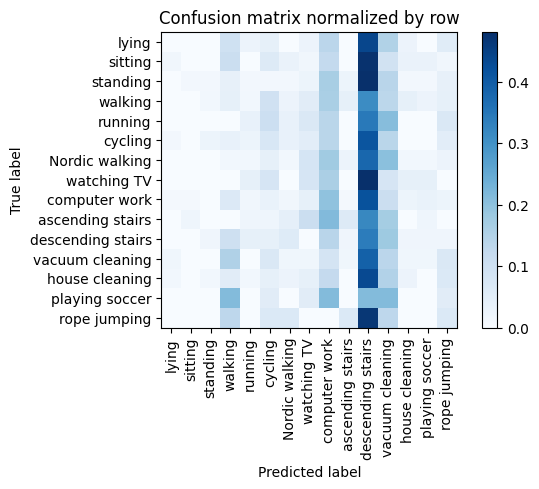

Training Epoch:  33%|███▎      | 5/15 [00:11<00:22,  2.24s/it]

Overall accuracy: 0.078



eval: 100%|██████████| 28/28 [00:00<00:00, 103.70batch/s, loss=1.86]


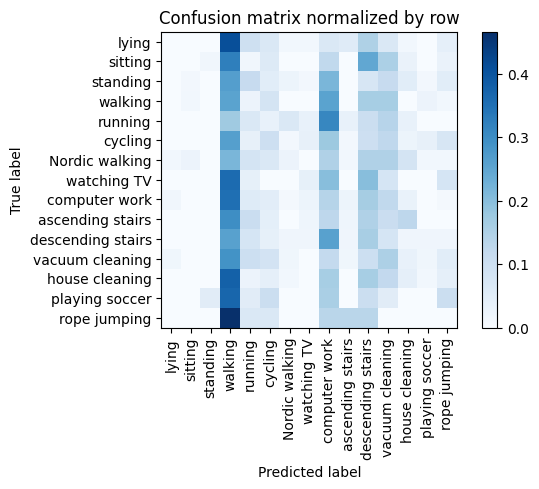

Training Epoch:  40%|████      | 6/15 [00:13<00:20,  2.24s/it]

Overall accuracy: 0.079



eval: 100%|██████████| 28/28 [00:00<00:00, 118.64batch/s, loss=2.97]


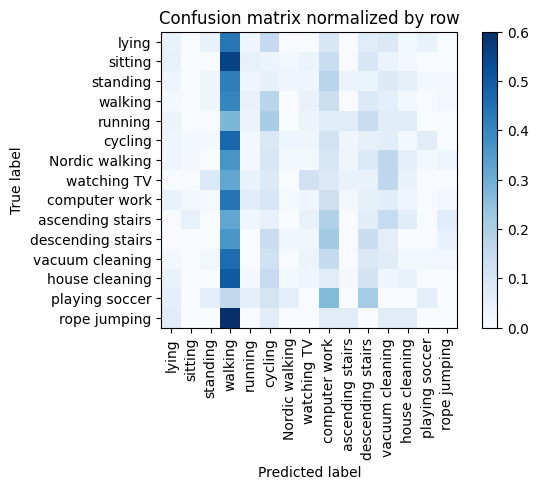

Training Epoch:  47%|████▋     | 7/15 [00:15<00:17,  2.24s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 28/28 [00:00<00:00, 112.90batch/s, loss=0.793]


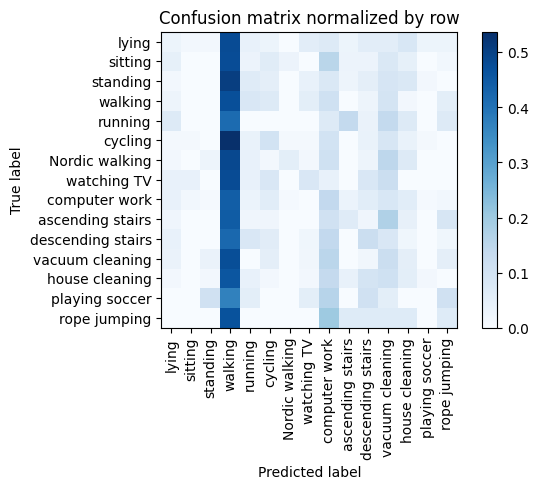

Training Epoch:  53%|█████▎    | 8/15 [00:18<00:15,  2.27s/it]

Overall accuracy: 0.101



eval: 100%|██████████| 28/28 [00:00<00:00, 116.18batch/s, loss=2.09]


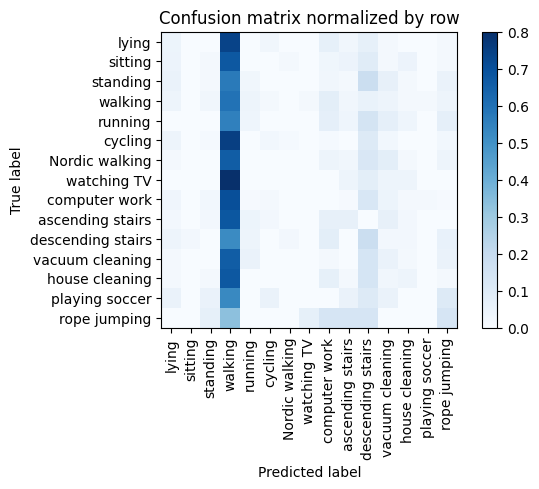

Training Epoch:  60%|██████    | 9/15 [00:20<00:13,  2.27s/it]

Overall accuracy: 0.080



eval: 100%|██████████| 28/28 [00:00<00:00, 117.65batch/s, loss=0.723]


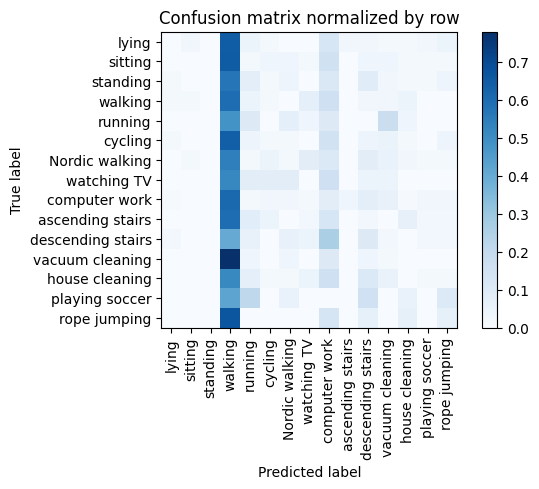

Training Epoch:  67%|██████▋   | 10/15 [00:22<00:11,  2.25s/it]

Overall accuracy: 0.075



eval: 100%|██████████| 28/28 [00:00<00:00, 111.11batch/s, loss=9.53]


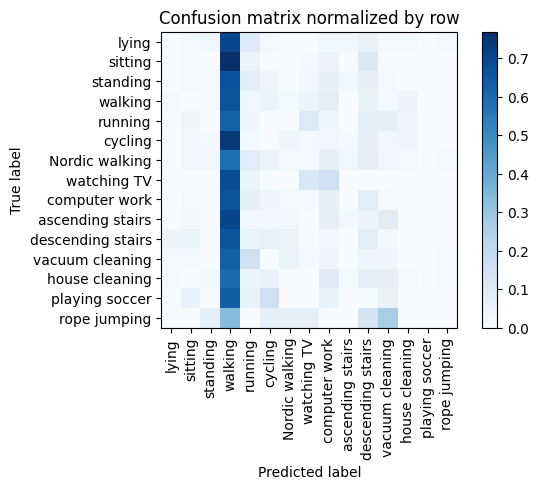

Training Epoch:  73%|███████▎  | 11/15 [00:24<00:08,  2.23s/it]

Overall accuracy: 0.082



eval: 100%|██████████| 28/28 [00:00<00:00, 110.67batch/s, loss=3.39]


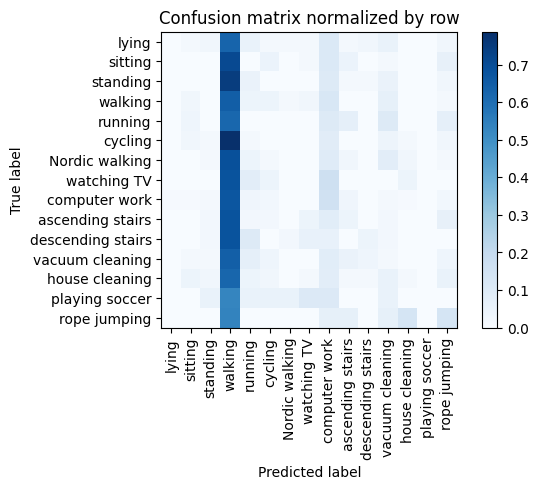

Training Epoch:  80%|████████  | 12/15 [00:27<00:06,  2.25s/it]

Overall accuracy: 0.085



eval: 100%|██████████| 28/28 [00:00<00:00, 117.65batch/s, loss=1.11]


Training Epoch:  87%|████████▋ | 13/15 [00:29<00:04,  2.21s/it]

Overall accuracy: 0.080



eval: 100%|██████████| 28/28 [00:00<00:00, 108.11batch/s, loss=0.595]


Training Epoch:  93%|█████████▎| 14/15 [00:31<00:02,  2.22s/it]

Overall accuracy: 0.081



eval: 100%|██████████| 28/28 [00:00<00:00, 110.24batch/s, loss=4.91]


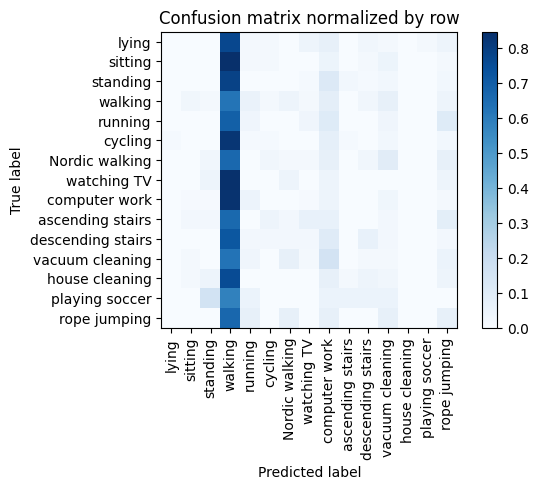

Overall accuracy: 0.067



eval: 100%|██████████| 19/19 [00:00<00:00, 103.82batch/s, loss=116] 


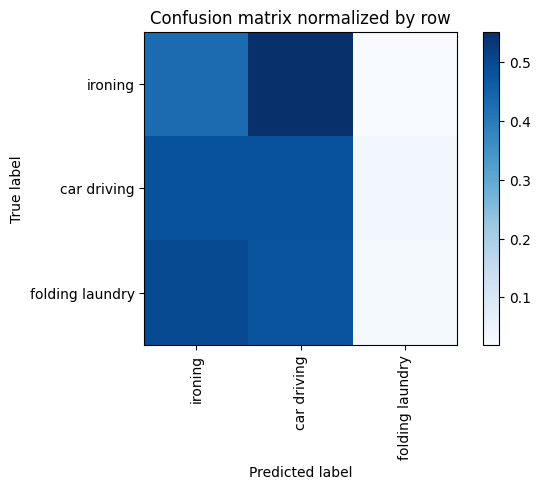

Overall accuracy: 0.334

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.566      0.429      0.488      0.599        359|	 car driving: 0.552,	folding laundry: 0.019,	
folding laundry       0.286      0.026      0.048      0.255        153|	 ironing: 0.497,	car driving: 0.477,	
    car driving       0.134      0.483      0.210      0.145         87|	 ironing: 0.483,	folding laundry: 0.034,	

----------------------------------------------------------------------------------------------------
    avg / total       0.432      0.334      0.335        1.0        599|	      

{'total_accuracy': 0.333889816360601, 'precision': 0.32869201993896596, 'recall': 0.3126239236236016, 'f1': 0.24867276540421537}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.265929
precision         0.263062
recall            0.274766
f1                0.202522
dtype: float64

In [9]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model5(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, attr_size=attr_size, max_len=seq_len)
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=True)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=True, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=True)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    